## 2.18 Homework

### Dataset

In this homework, we will use the New York City Airbnb Open Data. You can take it from
[Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

The goal of this homework is to create a regression model for prediction apartment prices (column `'price'`).

### EDA

* Load the data.
* Look at the `price` variable. Does it have a long tail? 


### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'price'`,
* `'minimum_nights'`,
* `'number_of_reviews'`,
* `'reviews_per_month'`,
* `'calculated_host_listings_count'`,
* `'availability_365'`

Select only them.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("AB_NYC_2019.csv")

In [3]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Exploratory Data Analysis

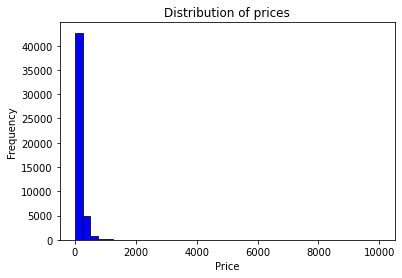

In [19]:
plt.figure(figsize=(6, 4))

sns.histplot(data.price, bins=40, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

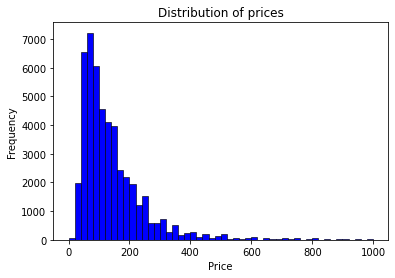

In [24]:
plt.figure(figsize=(6, 4))

sns.histplot(data.price[data.price < 1000], bins=50, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

### Yes, the price variable has a long tail

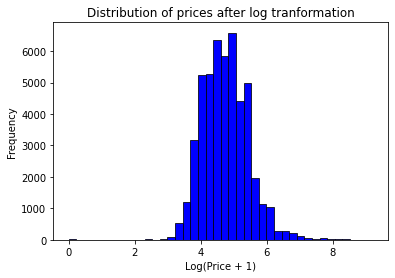

In [22]:
log_price = np.log1p(data.price)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

### Question 1

Find a feature with missing values. How many missing values does it have?

In [8]:
#selected features
features= ['latitude', 'longitude', 'price','minimum_nights', 'number_of_reviews',
           'reviews_per_month', 'calculated_host_listings_count','availability_365']

df_hw = data[features]

In [9]:
df_hw.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

"reviews_per_month" feature has 10052 missing values.

### Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

In [10]:
df_hw['minimum_nights'].median()

3.0

3.0 is the median for variable 'minimum_nights'

In [11]:
def create_data(df_hw, seed):
    
    np.random.seed(seed)
    
    df = df_hw.copy()
    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()



    y_train_orig = df_train.price.values
    y_val_orig = df_val.price.values
    y_test_orig = df_test.price.values

    del df_train['price']
    del df_val['price']
    del df_test['price']

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)
    
    return df_train, df_val, df_test, y_train, y_val, y_test

df_train, df_val, df_test, y_train, y_val, y_test=create_data(df_hw, 42)

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def prepare_X(df, na_val):
    df = df.fillna(0)
    X = df.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)


def training_lr(df_train, y_train, df_val, y_val, na_val):

    X_train = prepare_X(df_train, na_val)
    w_0, w = train_linear_regression(X_train, y_train)

    y_pred = w_0 + X_train.dot(w)
    print("RMSE of training data when missing values filled with ",na_val, " is ", round(rmse(y_train, y_pred),2))

    X_val = prepare_X(df_val, na_val)
    y_pred = w_0 + X_val.dot(w)
    print("RMSE of validation data when missing values filled with ",na_val, " is ", round(rmse(y_val, y_pred),2))
    print("\n")
    
# training linear regression by filling missing values with 0
training_lr(df_train, y_train, df_val, y_val, 0)

# training linear regression by filling missing values with mean
mean= df_train['reviews_per_month'].mean()
training_lr(df_train, y_train, df_val, y_val, mean)

RMSE of training data when missing values filled with  0  is  0.64
RMSE of validation data when missing values filled with  0  is  0.64


RMSE of training data when missing values filled with  1.3685492094776983  is  0.64
RMSE of validation data when missing values filled with  1.3685492094776983  is  0.64




### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [13]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

na_val=0
X_train = prepare_X(df_train, na_val)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
#     y_pred = w_0 + X_train.dot(w)
#     print("RMSE of training data when r= ",r, " is ", rmse(y_train, y_pred))

    X_val = prepare_X(df_val, na_val)
    y_pred = w_0 + X_val.dot(w)
    print("RMSE of validation data when r= ",r, " is ", round(rmse(y_val, y_pred),2))
    

RMSE of validation data when r=  0  is  0.64
RMSE of validation data when r=  1e-06  is  0.64
RMSE of validation data when r=  0.0001  is  0.64
RMSE of validation data when r=  0.001  is  0.64
RMSE of validation data when r=  0.01  is  0.66
RMSE of validation data when r=  0.1  is  0.68
RMSE of validation data when r=  1  is  0.68
RMSE of validation data when r=  5  is  0.68
RMSE of validation data when r=  10  is  0.68


We got best RMSE value for multiple r values. We choose the least r value. Here the least r value is 0.

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)


> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [14]:
def training_lr(df_train, y_train, df_val, y_val, na_val):

    X_train = prepare_X(df_train, na_val)
    w_0, w = train_linear_regression(X_train, y_train)

#     y_pred = w_0 + X_train.dot(w)
#     print("RMSE of training data when missing values filled with ",na_val, " is ", round(rmse(y_train, y_pred),2))

    X_val = prepare_X(df_val, na_val)
    y_pred = w_0 + X_val.dot(w)
    val_score=rmse(y_val, y_pred)
    print("RMSE of validation data when missing values filled with ",na_val, " is ", round(val_score,2))
    
    return val_score

In [15]:
rmse_scores=[]
for seed in range(10):
    
    print("Seed:", seed)
    
    df_train, df_val, df_test, y_train, y_val, y_test=create_data(df_hw, seed)
    
    na_val=0
    val_rmse = training_lr(df_train, y_train, df_val, y_val, na_val)
    rmse_scores.append(val_rmse)

Seed: 0
RMSE of validation data when missing values filled with  0  is  0.65
Seed: 1
RMSE of validation data when missing values filled with  0  is  0.65
Seed: 2
RMSE of validation data when missing values filled with  0  is  0.65
Seed: 3
RMSE of validation data when missing values filled with  0  is  0.64
Seed: 4
RMSE of validation data when missing values filled with  0  is  0.64
Seed: 5
RMSE of validation data when missing values filled with  0  is  0.63
Seed: 6
RMSE of validation data when missing values filled with  0  is  0.63
Seed: 7
RMSE of validation data when missing values filled with  0  is  0.65
Seed: 8
RMSE of validation data when missing values filled with  0  is  0.65
Seed: 9
RMSE of validation data when missing values filled with  0  is  0.64


In [16]:
print("Standard deviation of RMSE scores:", round(np.std(rmse_scores),3))

Standard deviation of RMSE scores: 0.008


### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [17]:
df_train, df_val, df_test, y_train, y_val, y_test=create_data(df_hw, 9)
df_combine = pd.concat([df_train, df_val])
y_combine = []
y_combine.extend(y_train)
y_combine.extend(y_val)



na_val=0
X_train = prepare_X(df_combine, na_val)

r=0.001
w_0, w = train_linear_regression_reg(X_train, y_combine, r=r)
X_val = prepare_X(df_test, na_val)
y_pred = w_0 + X_val.dot(w)
print("RMSE of test data when r= ",r, " is ", round(rmse(y_test, y_pred),2))   

RMSE of test data when r=  0.001  is  0.65
